In [1]:
# Importing Libraries and Loading Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Load data
file_path = r'R:\Portfolio_optimalization\akcje.txt'  # Adjust path if needed
data = pd.read_csv(file_path, sep=';', header=None)
data.columns = ['Day'] + [f'Stock_{i+1}' for i in range(data.shape[1] - 1)]
data.set_index('Day', inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')

# Display the first few rows of data
data.head()

,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5,Stock_6,Stock_7,Stock_8,Stock_9,Stock_10,Stock_11
Day,,,,,,,,,,,
1,3.25,12.7,71.5,11.4,4.5,35.2,6.8,26.3,17.1,33.20,0.67
2,3.25,12.9,73.0,11.6,4.5,34.9,7.2,25.4,17.1,33.54,0.68
3,3.20,12.8,74.5,12.0,4.5,34.9,7.1,24.4,16.9,33.20,0.68
4,3.15,13.0,72.5,12.0,4.5,34.7,7.0,24.0,17.2,33.02,0.67
5,3.25,13.0,75.0,11.6,4.3,34.7,6.9,22.4,16.8,35.26,0.65


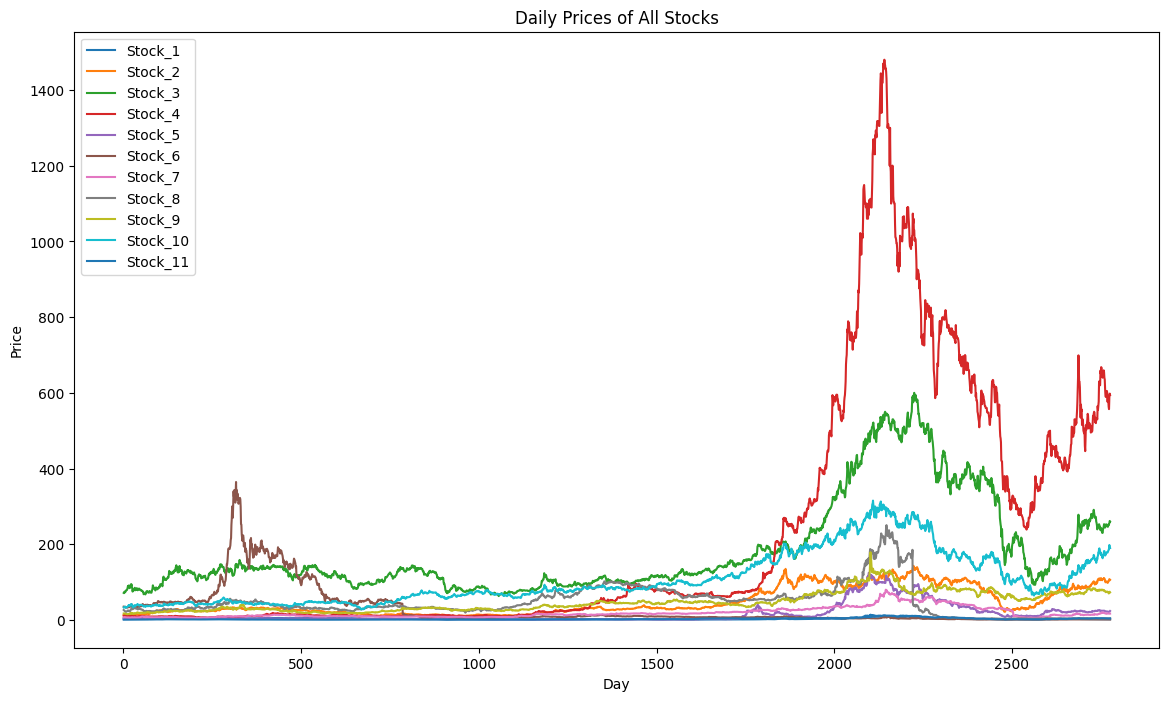

In [2]:
# 1. Plotting Daily Prices of All Stocks
plt.figure(figsize=(14, 8))
for column in data.columns:
    plt.plot(data.index, data[column], label=column)
plt.title('Daily Prices of All Stocks')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(loc="upper left")
plt.show()

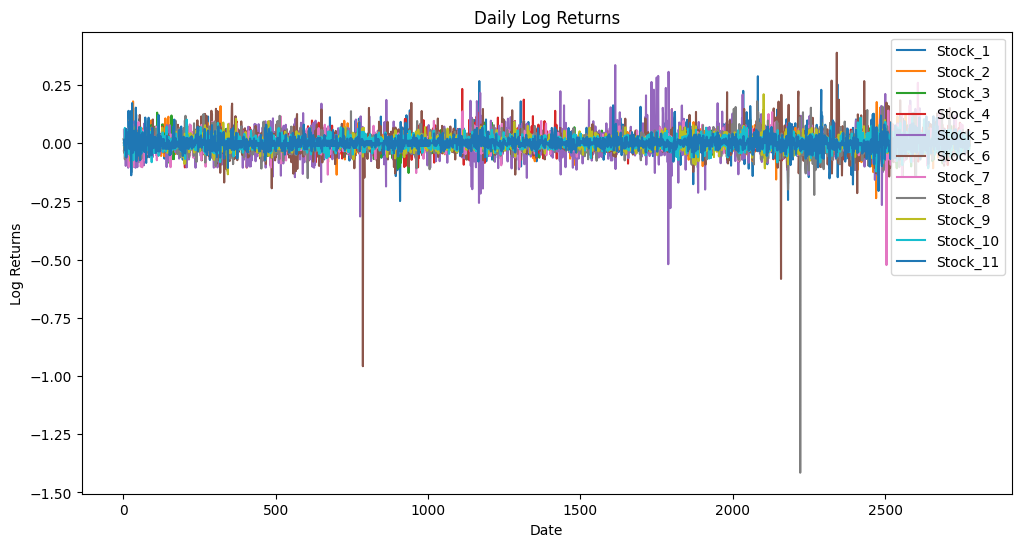

In [3]:
# 2. Calculate daily log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Plot Daily Log Returns
plt.figure(figsize=(12, 6))
plt.plot(log_returns)
plt.title("Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend(log_returns.columns, loc='upper right')
plt.show()

In [4]:
# 3. Covariance and Correlation Tables
cov_matrix = log_returns.cov() * 252  # Annualizing covariance matrix
corr_matrix = log_returns.corr()
cov_matrix

,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5,Stock_6,Stock_7,Stock_8,Stock_9,Stock_10,Stock_11
Stock_1,0.314178,0.083774,0.069625,0.045771,0.077652,0.103975,0.035826,0.059038,0.052039,0.069486,0.058409
Stock_2,0.083774,0.221971,0.079788,0.033014,0.061762,0.088844,0.035048,0.046755,0.043564,0.081228,0.052278
Stock_3,0.069625,0.079788,0.171309,0.033254,0.054174,0.072492,0.025237,0.056370,0.038786,0.081218,0.049883
Stock_4,0.045771,0.033014,0.033254,0.196267,0.038206,0.039047,0.032324,0.020159,0.023576,0.033374,0.027105
Stock_5,0.077652,0.061762,0.054174,0.038206,0.569201,0.054815,0.040004,0.046792,0.031242,0.045807,0.045594
Stock_6,0.103975,0.088844,0.072492,0.039047,0.054815,0.521984,0.023305,0.057244,0.055639,0.072274,0.055164
Stock_7,0.035826,0.035048,0.025237,0.032324,0.040004,0.023305,0.215078,0.023754,0.025209,0.030491,0.027681
Stock_8,0.059038,0.046755,0.056370,0.020159,0.046792,0.057244,0.023754,0.438070,0.035171,0.040146,0.045469
Stock_9,0.052039,0.043564,0.038786,0.023576,0.031242,0.055639,0.025209,0.035171,0.146435,0.037338,0.031934
Stock_10,0.069486,0.081228,0.081218,0.033374,0.045807,0.072274,0.030491,0.040146,0.037338,0.153290,0.047850


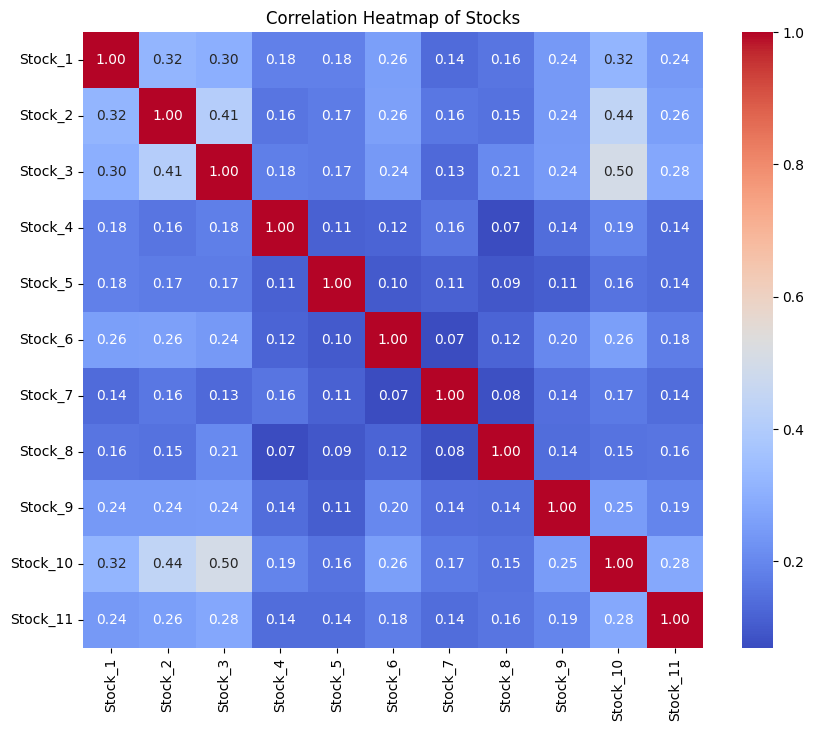

In [5]:
# 4. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Stocks")
plt.show()

In [6]:
# 5. Portfolio Optimization Functions
def portfolio_stats(weights):
    weights = np.array(weights)
    port_return = np.sum(log_returns.mean() * weights) * 252  # Annualizing returns
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Using annualized covariance matrix
    return {'return': port_return, 'risk': port_risk, 'sharpe': port_return / port_risk}

# Optimization functions
def minimize_sharpe(weights): return -portfolio_stats(weights)['sharpe']
def minimize_risk(weights): return portfolio_stats(weights)['risk']

num_assets = len(log_returns.columns)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

# Optimal portfolio for Maximum Sharpe Ratio
optimal_sharpe = minimize(minimize_sharpe, num_assets * [1. / num_assets], bounds=bounds, constraints=constraints)

# Minimum Risk Portfolio
optimal_risk = minimize(minimize_risk, num_assets * [1. / num_assets], bounds=bounds, constraints=constraints)

In [7]:
# 6. Target Return Portfolio for Efficient Frontier
def target_return_optimization(target):
    def portfolio_for_target(weights): return (portfolio_stats(weights)['return'] - target) ** 2
    result = minimize(portfolio_for_target, num_assets * [1. / num_assets], bounds=bounds, constraints=constraints)
    return result

In [8]:
# Generating Efficient Frontier by Varying Target Returns
target_returns = np.linspace(0, portfolio_stats(optimal_sharpe.x)['return'] + 0.1, 100)
minimal_risks = []
for target in target_returns:
    def target_return_constraint(weights):
        return portfolio_stats(weights)['return'] - target
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                   {'type': 'eq', 'fun': target_return_constraint})
    optimized = minimize(minimize_risk, num_assets * [1. / num_assets], bounds=bounds, constraints=constraints)
    minimal_risks.append(optimized.fun if optimized.success else np.nan)

minimal_risks = np.array(minimal_risks)

In [9]:
# 8. Monte Carlo Simulation for Random Portfolios
num_portfolios = 5000
portfolio_risks = []
portfolio_returns = []
for _ in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    stats = portfolio_stats(weights)
    portfolio_risks.append(stats['risk'])
    portfolio_returns.append(stats['return'])

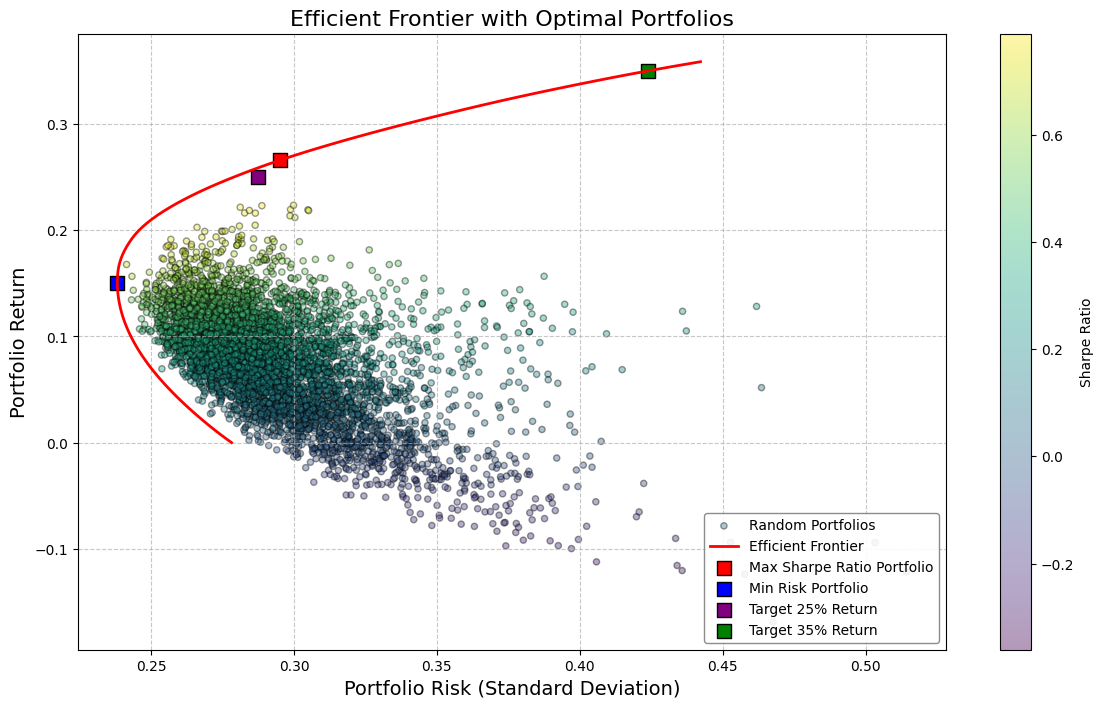

In [10]:
# 9. Final Plot with Efficient Frontier and Portfolio Points
plt.figure(figsize=(14, 8))

# Scatter plot of simulated portfolios
scatter = plt.scatter(portfolio_risks, portfolio_returns, c=np.array(portfolio_returns) / np.array(portfolio_risks),
                      marker='o', alpha=0.4, edgecolor='k', s=20, cmap='viridis', label='Random Portfolios')
plt.colorbar(scatter, label='Sharpe Ratio')

# Efficient Frontier Line
plt.plot(minimal_risks, target_returns, color='red', linestyle='-', linewidth=2, label='Efficient Frontier')

# Optimal portfolios with different markers for clarity
plt.scatter(portfolio_stats(optimal_sharpe.x)['risk'], portfolio_stats(optimal_sharpe.x)['return'],
            color='red', edgecolors='black', marker='s', s=100, label='Max Sharpe Ratio Portfolio')
plt.scatter(portfolio_stats(optimal_risk.x)['risk'], portfolio_stats(optimal_risk.x)['return'],
            color='blue', edgecolors='black', marker='s', s=100, label='Min Risk Portfolio')

# Target portfolios as squares at specific return levels
for target, color, label in zip([0.25, 0.35], ['purple', 'green'], ['25% Return', '35% Return']):
    weights = target_return_optimization(target).x
    plt.scatter(portfolio_stats(weights)['risk'], portfolio_stats(weights)['return'],
                color=color, edgecolors='black', marker='s', s=100, label=f'Target {label}')

# Final Plot Labels and Title
plt.xlabel('Portfolio Risk (Standard Deviation)', fontsize=14)
plt.ylabel('Portfolio Return', fontsize=14)
plt.legend(loc='lower right', frameon=True, framealpha=0.9, edgecolor='gray')
plt.title('Efficient Frontier with Optimal Portfolios', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

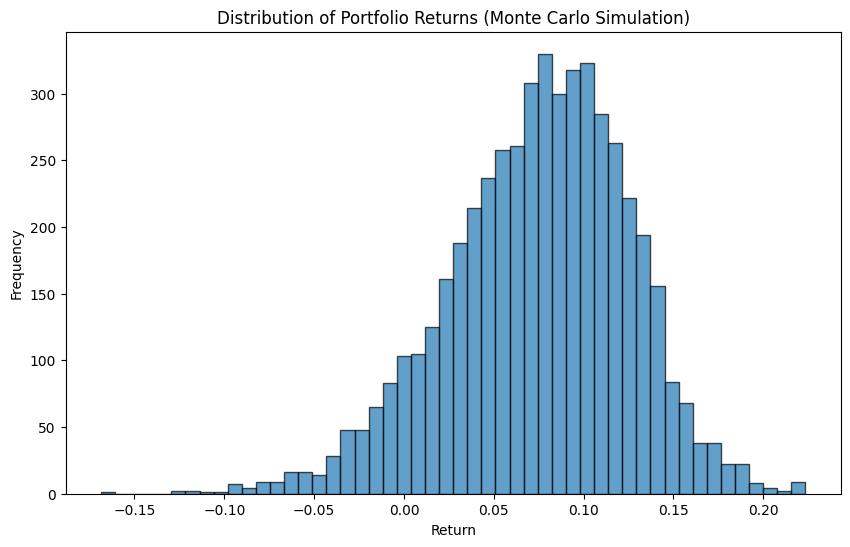

In [11]:
# 10. Histogram of Portfolio Returns
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Portfolio Returns (Monte Carlo Simulation)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()